In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/Brain Tumor MRI Dataset


[Errno 2] No such file or directory: '/content/drive/MyDrive/Brain Tumor MRI Dataset'
/content


In [5]:
!pip install colorama

In [4]:
import os
import random
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
print('Training dataset:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/glioma'))
print(Fore.BLUE + f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/meningioma'))
print(Fore.BLUE + f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/notumor'))
print(Fore.BLUE + f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/pituitary'))
print(Fore.BLUE + f'pituitary: {len(files)}\n')

print(Fore.WHITE + 'Testing:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/glioma'))
print(Fore.BLUE + f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/meningioma'))
print(Fore.BLUE + f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/notumor'))
print(Fore.BLUE + f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/pituitary'))
print(Fore.BLUE + f'pituitary: {len(files)}\n')

Training dataset:

glioma: 1331
meningioma: 1339
notumor: 1595
pituitary: 1458

Testing:

glioma: 310
meningioma: 306
notumor: 405
pituitary: 300



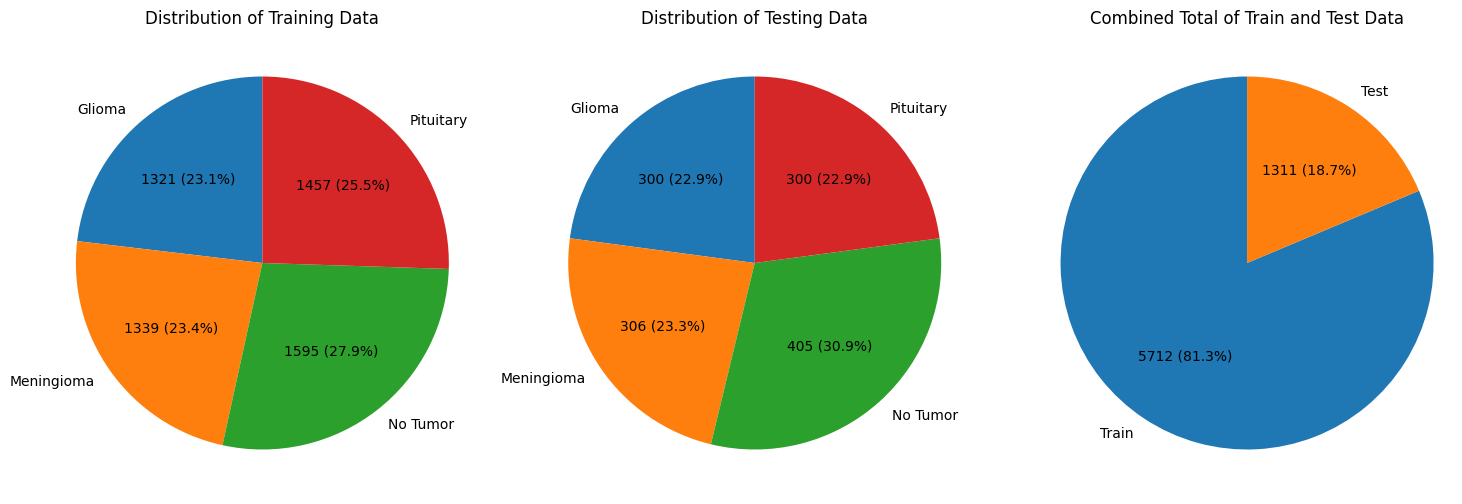

In [7]:
# Data for training and testing
train_counts = [1321, 1339, 1595, 1457]
test_counts = [300, 306, 405, 300]
labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

total_train = sum(train_counts)
total_test = sum(test_counts)
total_labels = ['Train', 'Test']
total_counts = [total_train, total_test]

# Custom function for autopct to ensure accurate numbers
def custom_autopct(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{absolute} ({pct:.1f}%)"

def plot_pie_chart(data, labels, title, ax):
    ax.pie(data, labels=labels, autopct=lambda pct: custom_autopct(pct, data), startangle=90)
    ax.axis('equal')
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_pie_chart(train_counts, labels, "Distribution of Training Data", axs[0])
plot_pie_chart(test_counts, labels, "Distribution of Testing Data", axs[1])
plot_pie_chart(total_counts, total_labels, "Combined Total of Train and Test Data", axs[2])

plt.show()


In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='training',
                                             label_mode = 'categorical',
                                             seed=42)

validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='validation',
                                             label_mode = 'categorical',
                                             seed=42)

test_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode = 'categorical',
                                            )
# prefetch the train_dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5723 files belonging to 4 classes.
Using 4865 files for training.
Found 5723 files belonging to 4 classes.
Using 858 files for validation.
Found 1321 files belonging to 4 classes.


In [9]:
# this cell to enable me to evaluate the model in confusion matrix
y_true = np.concatenate([ y for _ , y in test_dataset] , axis = 0)

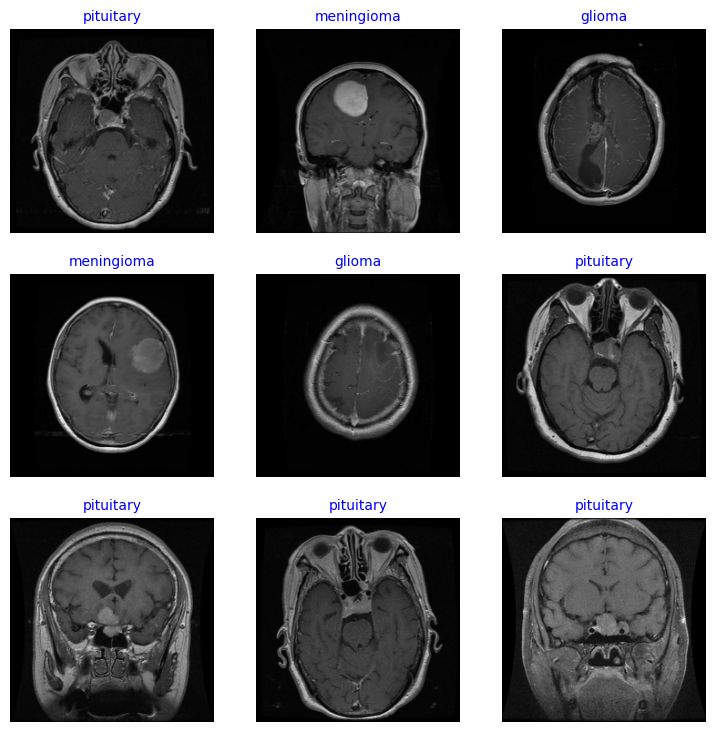

In [10]:
class_names = test_dataset.class_names
plt.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])] , c = 'blue' , size = 10)
    plt.axis("off")


In [11]:
# Hyperparameters
from tensorflow.keras.optimizers import legacy

IMG_SHAPE = IMG_SIZE + (3,)
LOSS = keras.losses.CategoricalCrossentropy()
OPTIMIZER = legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
SEED = 42

In [12]:
# callbacks for the models
def get_callbacks (model_name):
  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'model.{model_name}.h5', monitor = 'val_loss', verbose = 1 ,
                                                    mode = 'min', save_best_only=True, save_freq='epoch')
  callbacks.append(checkpoint)
  rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
  callbacks.append(rlr)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
  callbacks.append(earlystop)

  return callbacks

In [13]:
# function for plot resultes

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

# for make dataframe for all model
model_name= ['My_model','DenseNet121','VGG16','ResNet50V2','MobileNetV2','EfficientNetV2S','Xception']
CategoricalAccuracy= []
losses= []

In [ ]:
model = Sequential([
    tfl.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(64, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(128, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(256, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Flatten(),
    tfl.Dense(512, activation='relu'),
    tfl.Dropout(0.5),
    tfl.Dense(4, activation='softmax')
])

model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('my_model')
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
153/153 [==============================] - ETA: 0s - loss: 6.2642 - categorical_accuracy: 0.6935
Epoch 1: val_loss improved from inf to 0.74986, saving model to model.my_model.h5
153/153 [==============================] - 1045s 7s/step - loss: 6.2642 - categorical_accuracy: 0.6935 - val_loss: 0.7499 - val_categorical_accuracy: 0.7517 - lr: 0.0010
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.4233 - categorical_accuracy: 0.8497
Epoch 2: val_loss improved from 0.74986 to 0.55737, saving model to model.my_model.h5
153/153 [==============================] - 25s 158ms/step - loss: 0.4232 - categorical_accuracy: 0.8497 - val_loss: 0.5574 - val_categorical_accuracy: 0.7984 - lr: 0.0010
Epoch 3/10
152/153 [============================>.] - ETA: 0s - loss: 0.3248 - categorical_accuracy: 0.8828
Epoch 3: val_loss improved from 0.55737 to 0.30581, saving model to model.my_model.h5
153/153 [==============================] - 27s 170ms/step - loss: 0.3248 - catego

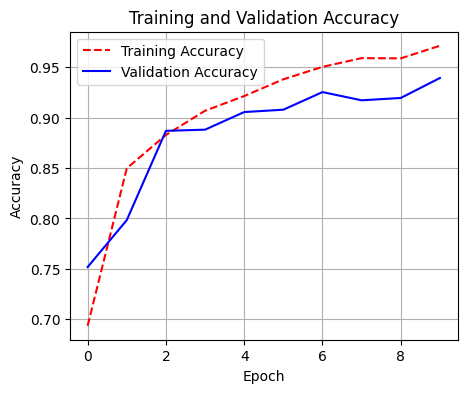

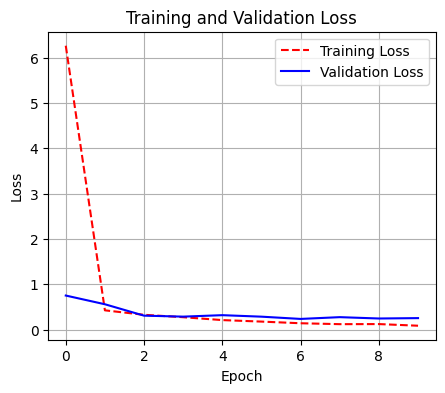

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(history):
    # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)

    # Plot training and validation accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['categorical_accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history_df['val_categorical_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['loss'], 'r--', label='Training Loss')
    plt.plot(history_df['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and stored the history object
plot(history)


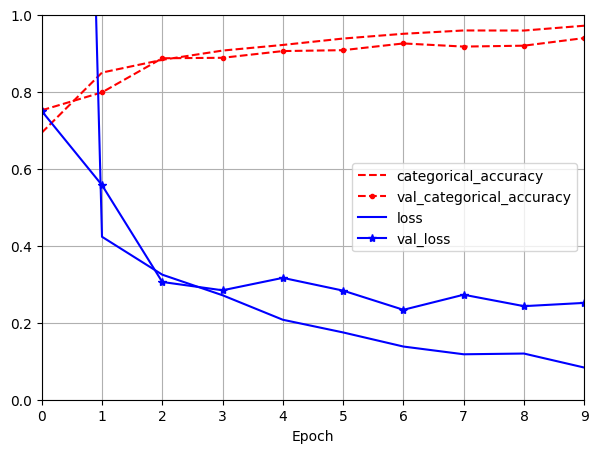

In [ ]:
def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

42/42 [==============================] - 6s 133ms/step - loss: 0.2649 - categorical_accuracy: 0.9273


In [ ]:
# Print model summaries
print("CNN Model 1 Summary:")
model.summary()

CNN Model 1 Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None,

42/42 [==============================] - 5s 119ms/step - loss: 0.2649 - categorical_accuracy: 0.9273
CNN Model 1 - Test accuracy: 0.9273, Test loss: 0.2649
42/42 [==============================] - 5s 118ms/step

Classification Report for CNN Model 1:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       310
           1       0.86      0.85      0.85       306
           2       0.93      1.00      0.96       405
           3       0.97      0.95      0.96       300

    accuracy                           0.93      1321
   macro avg       0.93      0.92      0.92      1321
weighted avg       0.93      0.93      0.93      1321



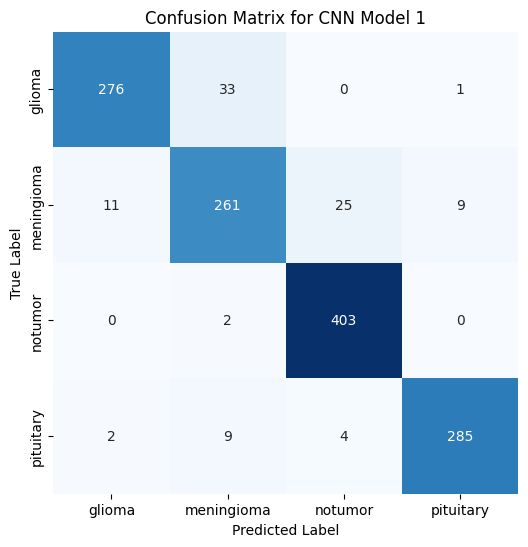

---


In [ ]:
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def evaluate_model(model, name, test_dataset):
    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"{name} - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # Generate predictions for the test set
    predictions = model.predict(test_dataset)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Convert labels to numpy array for classification report
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
    true_labels = np.array(true_labels)

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(true_labels, predicted_labels))

    # Create a colorful confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print("---")

# Now you can call the evaluate_model function with your datasets
evaluate_model(model, "CNN Model 1", test_dataset)


In [14]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_vgg16 = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_vgg16 = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_vgg16 = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import VGG16

VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
VGG16_model.trainable = False

x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=VGG16_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('VGG16')
history = model.fit(
    train_dataset_vgg16,
    epochs=10,
    validation_data=validation_dataset_vgg16,
    callbacks=callbacks
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
153/153 [==============================] - ETA: 0s - loss: 0.5526 - categorical_accuracy: 0.8230
Epoch 1: val_loss improved from inf to 0.28010, saving model to model.VGG16.h5
153/153 [==============================] - 1192s 8s/step - loss: 0.5526 - categorical_accuracy: 0.8230 - val_loss: 0.2801 - val_categorical_accuracy: 0.8928 - lr: 0.0010
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.2177 - categorical_accuracy: 0.9147
Epoch 2: val_loss improved from 0.28010 to 0.22858, saving model to model.VGG16.h5
153/153 [==============================] - 38s 235ms/step - loss: 0.2176 - categorical_accuracy: 0.9147 - val_loss: 0.2286 - val_categorical_accuracy: 0.9114 - lr: 0.0010
Epoch 3/10
152/153 [============================>.] - ETA: 0s - loss: 0.1470 - categorical_accuracy: 0.9418
Epoch 3: val_loss improved from 0.22858 to 0.18039, saving model to model.VGG16.h5
153/153 [================

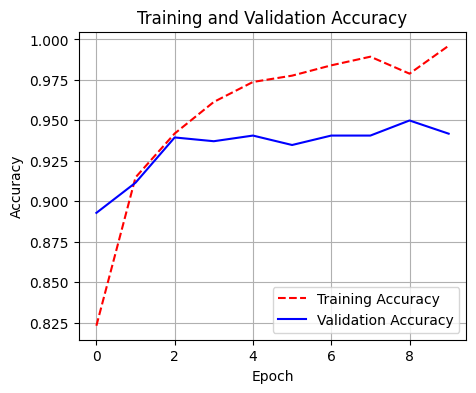

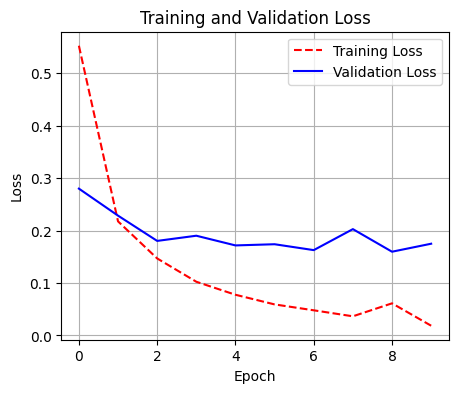

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(history):
    # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)

    # Plot training and validation accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['categorical_accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history_df['val_categorical_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['loss'], 'r--', label='Training Loss')
    plt.plot(history_df['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and stored the history object
plot(history)


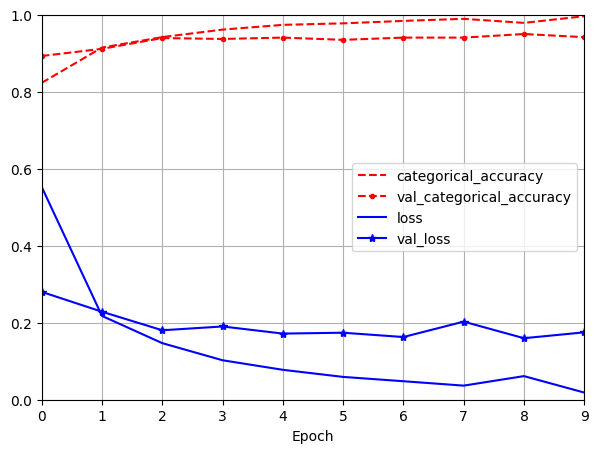

In [16]:
def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

plot()

In [17]:
loss, categorical_accuracy = model.evaluate(test_dataset_vgg16)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

42/42 [==============================] - 11s 252ms/step - loss: 0.1984 - categorical_accuracy: 0.9432


42/42 [==============================] - 9s 214ms/step - loss: 0.1984 - categorical_accuracy: 0.9432
VGG -16 - Test accuracy: 0.9432, Test loss: 0.1984
42/42 [==============================] - 8s 177ms/step

Classification Report for VGG -16:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       310
           1       0.84      0.96      0.89       306
           2       0.98      1.00      0.99       405
           3       0.98      0.94      0.96       300

    accuracy                           0.94      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.95      0.94      0.94      1321



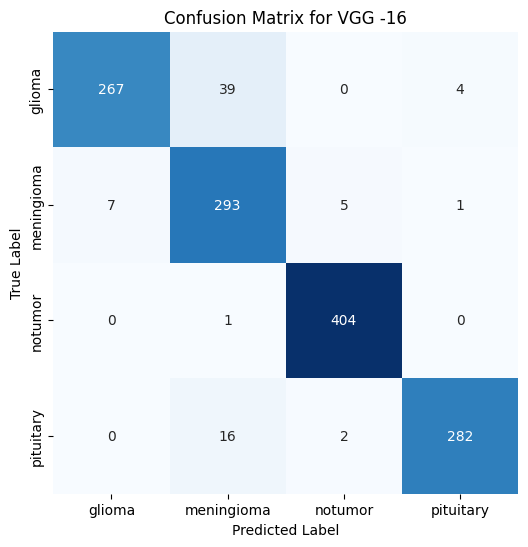

---


In [18]:
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def evaluate_model(model, name, test_dataset):
    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"{name} - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # Generate predictions for the test set
    predictions = model.predict(test_dataset)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Convert labels to numpy array for classification report
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
    true_labels = np.array(true_labels)

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(true_labels, predicted_labels))

    # Create a colorful confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print("---")

# Now you can call the evaluate_model function with your datasets
evaluate_model(model, "VGG -16", test_dataset_vgg16)


MobileNet

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_mobilenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_mobilenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_mobilenet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import MobileNetV2
MobileNet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
MobileNet_model.trainable = False

x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=MobileNet_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('MobileNetV2')
history = model.fit(
    train_dataset_mobilenet,
    epochs=10,
    validation_data=validation_dataset_mobilenet,
    callbacks=callbacks
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
153/153 [==============================] - ETA: 0s - loss: 0.4784 - categorical_accuracy: 0.8364
Epoch 1: val_loss improved from inf to 0.35750, saving model to model.MobileNetV2.h5
153/153 [==============================] - 33s 178ms/step - loss: 0.4784 - categorical_accuracy: 0.8364 - val_loss: 0.3575 - val_categorical_accuracy: 0.8566 - lr: 0.0010
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.2105 - categorical_accuracy: 0.9221
Epoch 2: val_loss improved from 0.35750 to 0.22974, saving model to model.MobileNetV2.h5
153/153 [==============================] - 25s 159ms/step - loss: 0.2105 - categorical_accuracy: 0.9221 - val_loss: 0.2297 - val_categorical_accuracy: 0.9056 - lr: 0.0010
Epoch 3/10
153/153 [==============================] - ETA: 0s - loss: 0.1546 - categorical_accuracy: 0.9441
Epoch 3: val_loss improved from 0.22974 to 0.18632, saving model to model.MobileNetV2.h5
153/153 

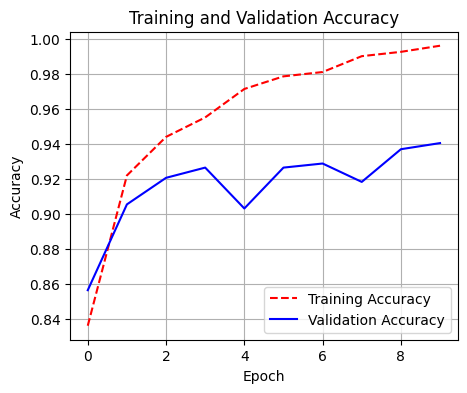

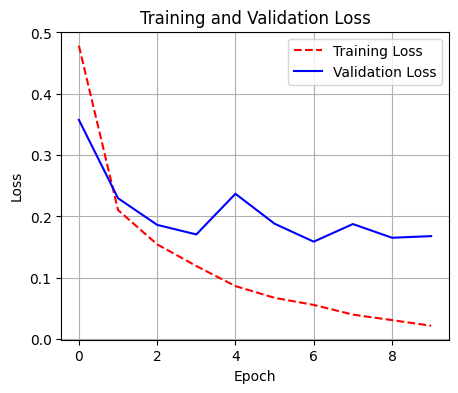

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(history):
    # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)

    # Plot training and validation accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['categorical_accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history_df['val_categorical_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['loss'], 'r--', label='Training Loss')
    plt.plot(history_df['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and stored the history object
plot(history)


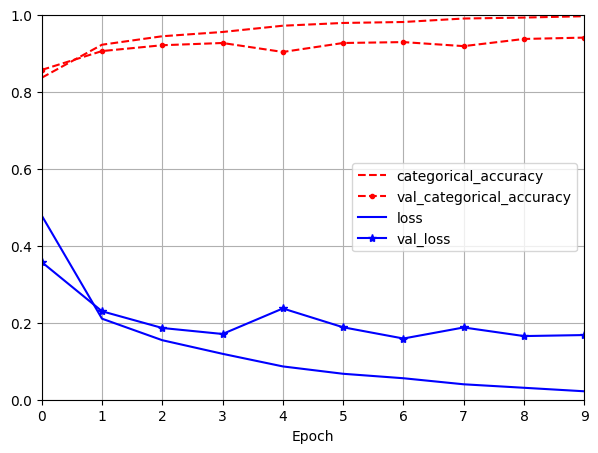

In [ ]:
def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_mobilenet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

42/42 [==============================] - 5s 123ms/step - loss: 0.1484 - categorical_accuracy: 0.9447


42/42 [==============================] - 5s 124ms/step - loss: 0.1484 - categorical_accuracy: 0.9447
MobileNetV2 - Test accuracy: 0.9447, Test loss: 0.1484
42/42 [==============================] - 6s 132ms/step

Classification Report for MobileNetV2:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       310
           1       0.87      0.91      0.89       306
           2       0.99      0.99      0.99       405
           3       0.98      0.94      0.96       300

    accuracy                           0.94      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.95      0.94      0.95      1321



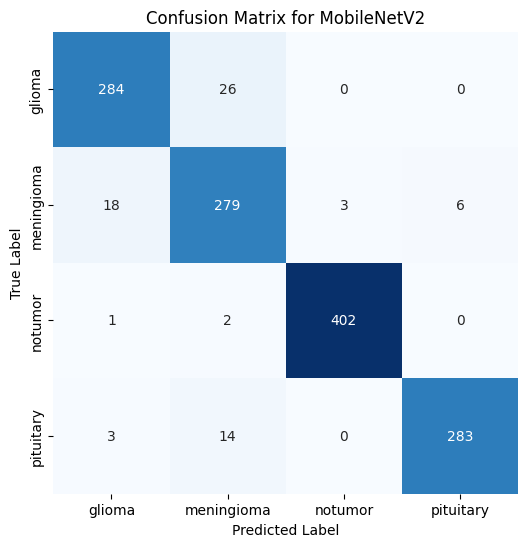

---


In [ ]:
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def evaluate_model(model, name, test_dataset):
    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"{name} - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # Generate predictions for the test set
    predictions = model.predict(test_dataset)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Convert labels to numpy array for classification report
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
    true_labels = np.array(true_labels)

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(true_labels, predicted_labels))

    # Create a colorful confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print("---")

# Now you can call the evaluate_model function with your datasets
evaluate_model(model, "MobileNetV2", test_dataset_mobilenet)


Resnet

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.resnet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_resnet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_resnet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_resnet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import ResNet50V2
ResNet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
ResNet_model.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=ResNet_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('ResNet50V2')
history = model.fit(
    train_dataset_resnet,
    epochs=10,
    validation_data=validation_dataset_resnet,
    callbacks=callbacks
)

94668760/94668760 [==============================] - 3s 0us/step
Epoch 1/10
153/153 [==============================] - ETA: 0s - loss: 0.4329 - categorical_accuracy: 0.8438
Epoch 1: val_loss improved from inf to 0.24955, saving model to model.ResNet50V2.h5
153/153 [==============================] - 1218s 8s/step - loss: 0.4329 - categorical_accuracy: 0.8438 - val_loss: 0.2495 - val_categorical_accuracy: 0.9056 - lr: 0.0010
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.1943 - categorical_accuracy: 0.9258
Epoch 2: val_loss improved from 0.24955 to 0.18751, saving model to model.ResNet50V2.h5
153/153 [==============================] - 26s 165ms/step - loss: 0.1942 - categorical_accuracy: 0.9258 - val_loss: 0.1875 - val_categorical_accuracy: 0.9266 - lr: 0.0010
Epoch 3/10
152/153 [============================>.] - ETA: 0s - loss: 0.1270 - categorical_accuracy: 0.9562
Epoch 3: val_loss did not improve from 0.18751
153/153 [==============================] - 26s 162m

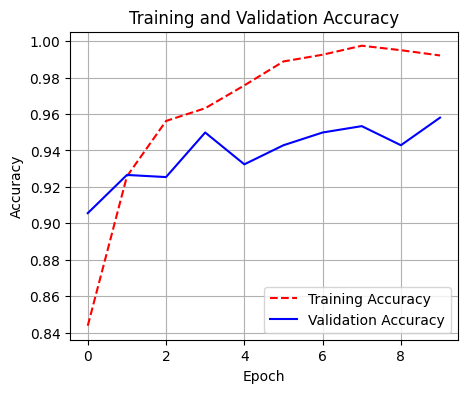

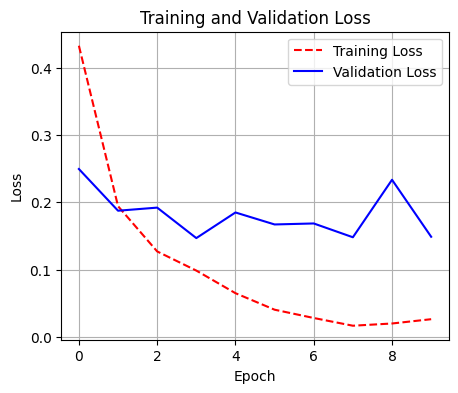

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(history):
    # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)

    # Plot training and validation accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['categorical_accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history_df['val_categorical_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['loss'], 'r--', label='Training Loss')
    plt.plot(history_df['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and stored the history object
plot(history)


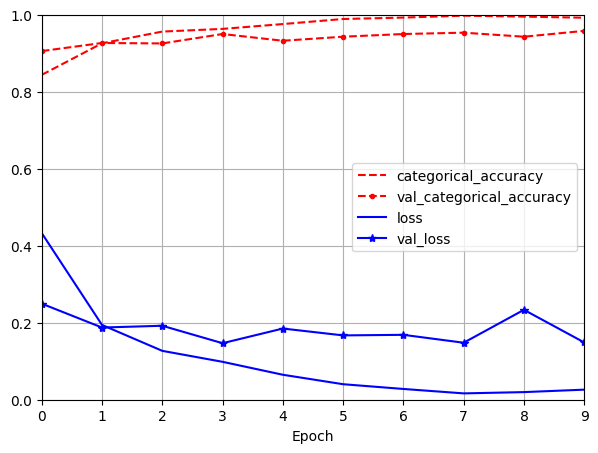

In [ ]:
def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_resnet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

42/42 [==============================] - 6s 139ms/step - loss: 0.1290 - categorical_accuracy: 0.9553


42/42 [==============================] - 4s 103ms/step - loss: 0.1290 - categorical_accuracy: 0.9553
ResNet50V2 - Test accuracy: 0.9553, Test loss: 0.1290
42/42 [==============================] - 7s 152ms/step

Classification Report for ResNet50V2:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       310
           1       0.90      0.93      0.91       306
           2       1.00      0.99      1.00       405
           3       0.98      0.98      0.98       300

    accuracy                           0.96      1321
   macro avg       0.95      0.95      0.95      1321
weighted avg       0.96      0.96      0.96      1321



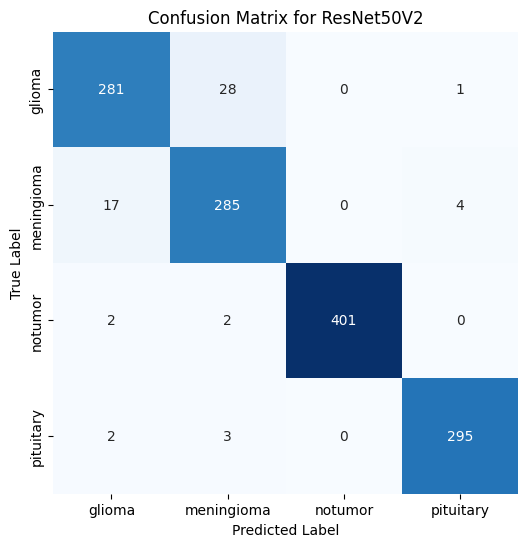

---


In [ ]:
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def evaluate_model(model, name, test_dataset):
    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"{name} - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # Generate predictions for the test set
    predictions = model.predict(test_dataset)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Convert labels to numpy array for classification report
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
    true_labels = np.array(true_labels)

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(true_labels, predicted_labels))

    # Create a colorful confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print("---")

# Now you can call the evaluate_model function with your datasets
evaluate_model(model, "ResNet50V2", test_dataset_resnet)


In [2]:

tf.keras.utils.plot_model(keras.models.load_model('model.ResNet50V2.h5'), show_shapes=True)

NameError: name 'tf' is not defined

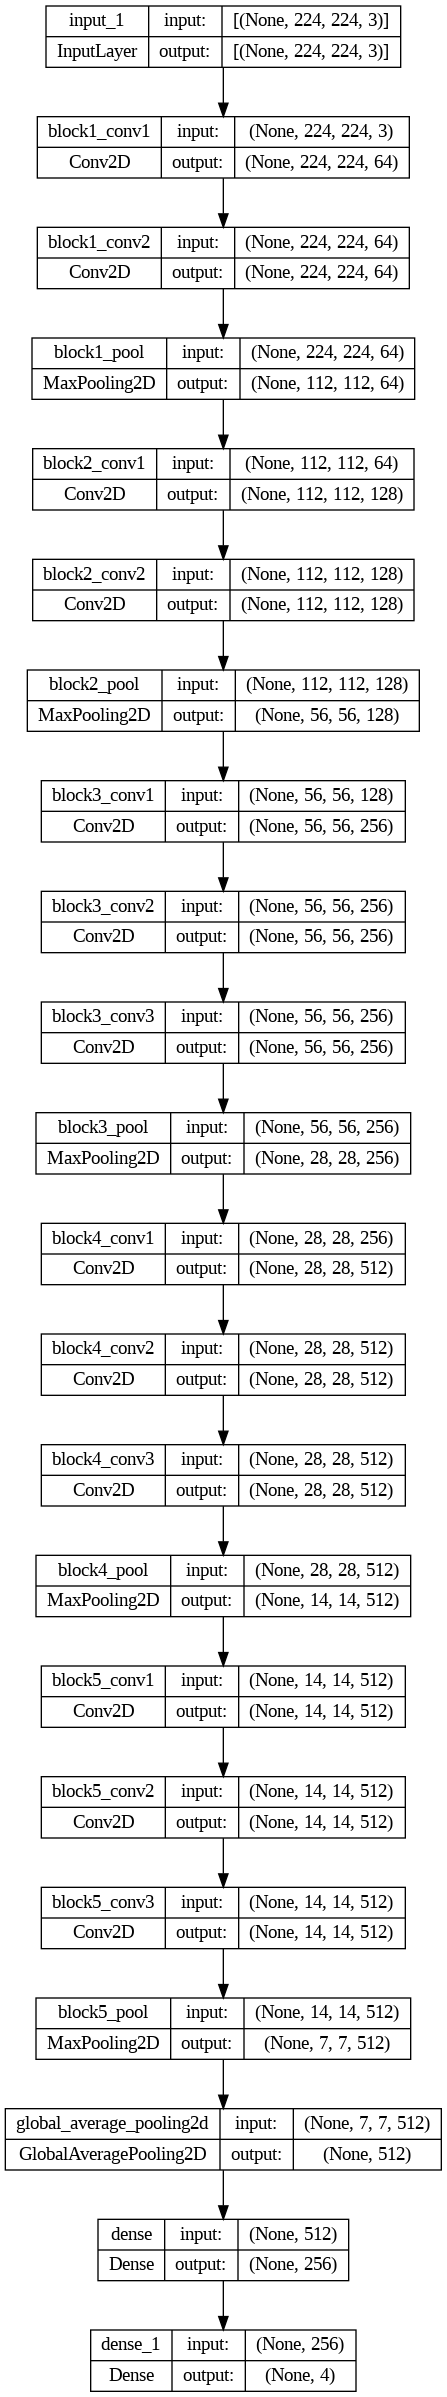

In [ ]:
best_model = keras.models.load_model('model.VGG16.h5')
tf.keras.utils.plot_model(best_model, show_shapes=True)

#VGG Tuning

In [19]:
vgg_tuning = keras.models.load_model('/content/drive/MyDrive/Brain Tumor MRI Dataset/model.VGG16.h5')

In [20]:
for layer in vgg_tuning.layers[:17]:
    layer.trainable = False
# Set the last 5 layers to trainable
for layer in vgg_tuning.layers[17:]:
    layer.trainable = True

callbacks = get_callbacks('vgg_tuning')
history = vgg_tuning.fit(
    train_dataset_vgg16,
    epochs=10,
    validation_data=validation_dataset_vgg16,
    callbacks=callbacks
)

Epoch 1/10
152/153 [============================>.] - ETA: 0s - loss: 0.0175 - categorical_accuracy: 0.9961
Epoch 1: val_loss improved from inf to 0.17913, saving model to model.vgg_tuning.h5
153/153 [==============================] - 45s 280ms/step - loss: 0.0175 - categorical_accuracy: 0.9961 - val_loss: 0.1791 - val_categorical_accuracy: 0.9394 - lr: 0.0010
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.0125 - categorical_accuracy: 0.9984
Epoch 2: val_loss improved from 0.17913 to 0.14908, saving model to model.vgg_tuning.h5
153/153 [==============================] - 43s 266ms/step - loss: 0.0125 - categorical_accuracy: 0.9984 - val_loss: 0.1491 - val_categorical_accuracy: 0.9534 - lr: 0.0010
Epoch 3/10
152/153 [============================>.] - ETA: 0s - loss: 0.0088 - categorical_accuracy: 0.9992
Epoch 3: val_loss improved from 0.14908 to 0.14122, saving model to model.vgg_tuning.h5
153/153 [==============================] - 38s 239ms/step - loss: 0.0088 -

In [21]:
loss, categorical_accuracy = vgg_tuning.evaluate(test_dataset_vgg16)

42/42 [==============================] - 9s 200ms/step - loss: 0.1400 - categorical_accuracy: 0.9667


In [22]:
y_true = np.argmax(y_true, axis=1)
y_pred = vgg_tuning.predict(test_dataset_vgg16)
y_pred = np.argmax(y_pred, axis=1)

42/42 [==============================] - 8s 179ms/step


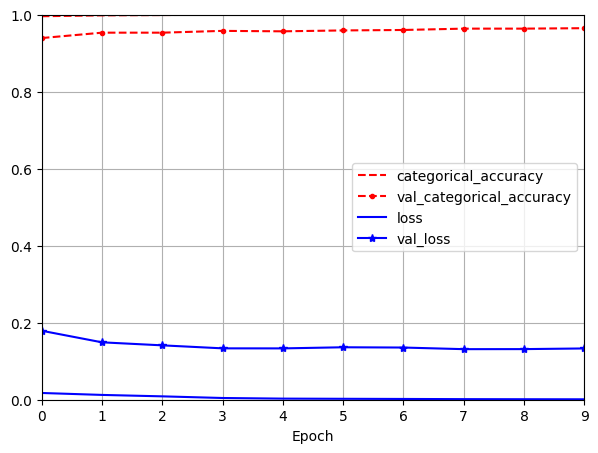

In [23]:
plot()

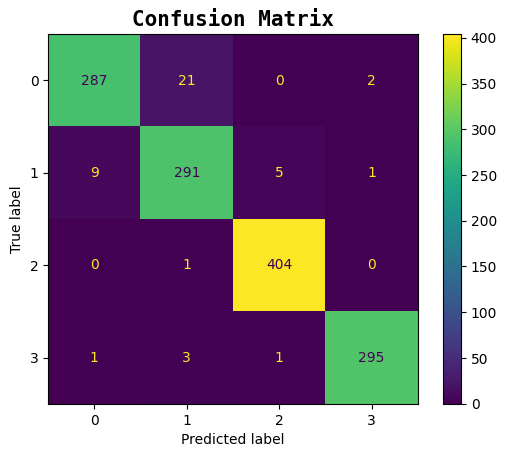

In [24]:
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true , y_pred)
plt.title("Confusion Matrix", fontname = "monospace", fontsize = 15, weight = "bold")
plt.show()

In [25]:
print("\nClassification Report:\n")
print(Fore.BLUE + classification_report(y_true, y_pred, target_names = class_names, digits= 4))


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9663    0.9258    0.9456       310
  meningioma     0.9209    0.9510    0.9357       306
     notumor     0.9854    0.9975    0.9914       405
   pituitary     0.9899    0.9833    0.9866       300

    accuracy                         0.9667      1321
   macro avg     0.9656    0.9644    0.9648      1321
weighted avg     0.9670    0.9667    0.9667      1321



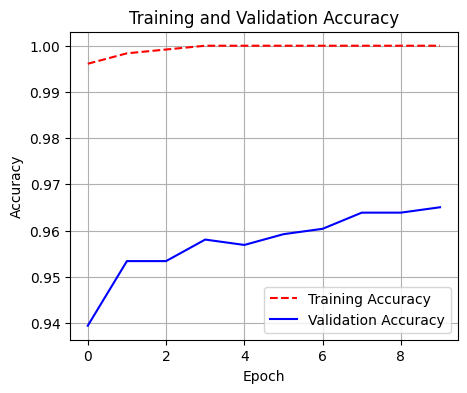

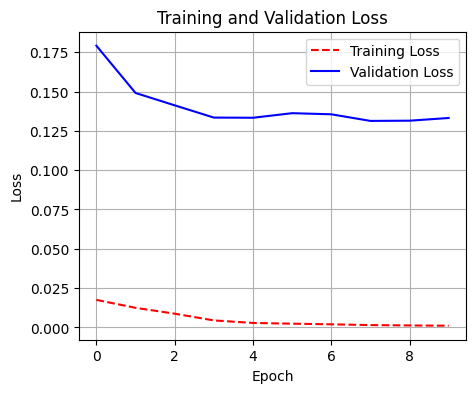

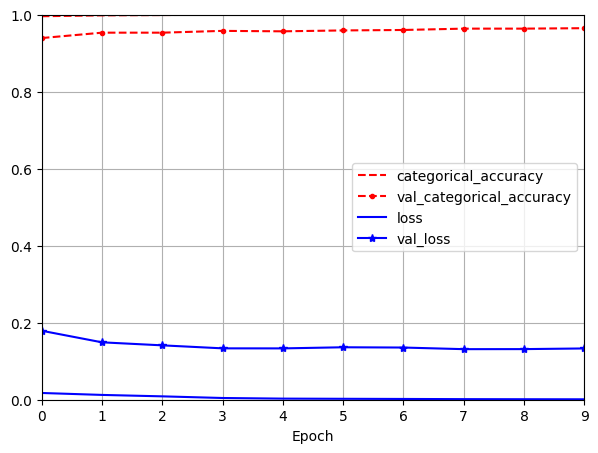

42/42 [==============================] - 9s 213ms/step - loss: 0.1400 - categorical_accuracy: 0.9667


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(history):
    # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)

    # Plot training and validation accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['categorical_accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history_df['val_categorical_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['loss'], 'r--', label='Training Loss')
    plt.plot(history_df['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and stored the history object
plot(history)

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

plot()

loss, categorical_accuracy = vgg_tuning.evaluate(test_dataset_vgg16)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

## VGG Data Augmentation

In [27]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [28]:
vgg_tuning = keras.models.load_model('/content/drive/MyDrive/Brain Tumor MRI Dataset/model.vgg_tuning.h5')

# Define image size
IMG_SIZE = (224, 224)

# Load and preprocess a single image for testing
img_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/glioma/Tr-glTr_0000.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Create ImageDataGenerator for data augmentation
datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = []
for batch in datagen.flow(img_array, batch_size=1):
    augmented_images.append(batch)
    if len(augmented_images) >= 5:  # Generate 5 augmented images
        break

1/1 [==============================] - 0s 17ms/step


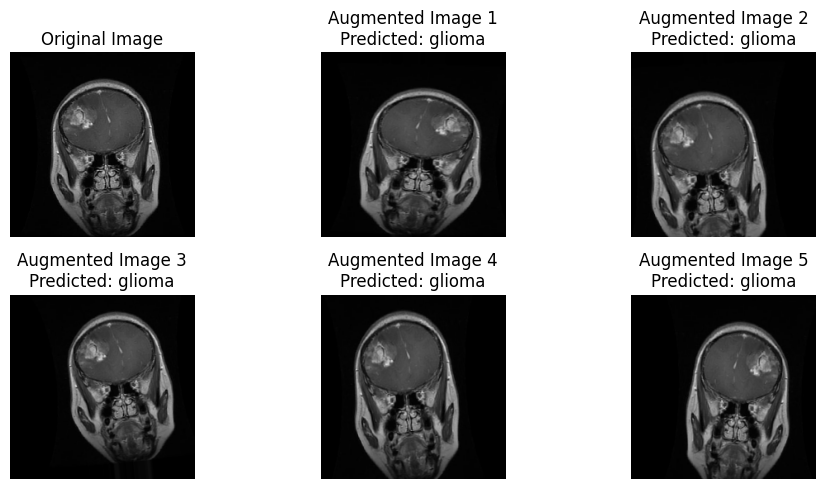

In [29]:
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Plot the augmented images and their predictions
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 3, i+2)
    plt.imshow(np.squeeze(augmented_img))
    predictions = vgg_tuning.predict(augmented_img)
    predicted_label = class_labels[np.argmax(predictions)]
    plt.title(f'Augmented Image {i+1}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale = None,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function= preprocess_input
)

# For testing, we just preprocess
test_val_datagen = ImageDataGenerator(rescale = None, preprocessing_function= preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle= True,
    seed=42
)


test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5723 images belonging to 4 classes.
Found 1321 images belonging to 4 classes.


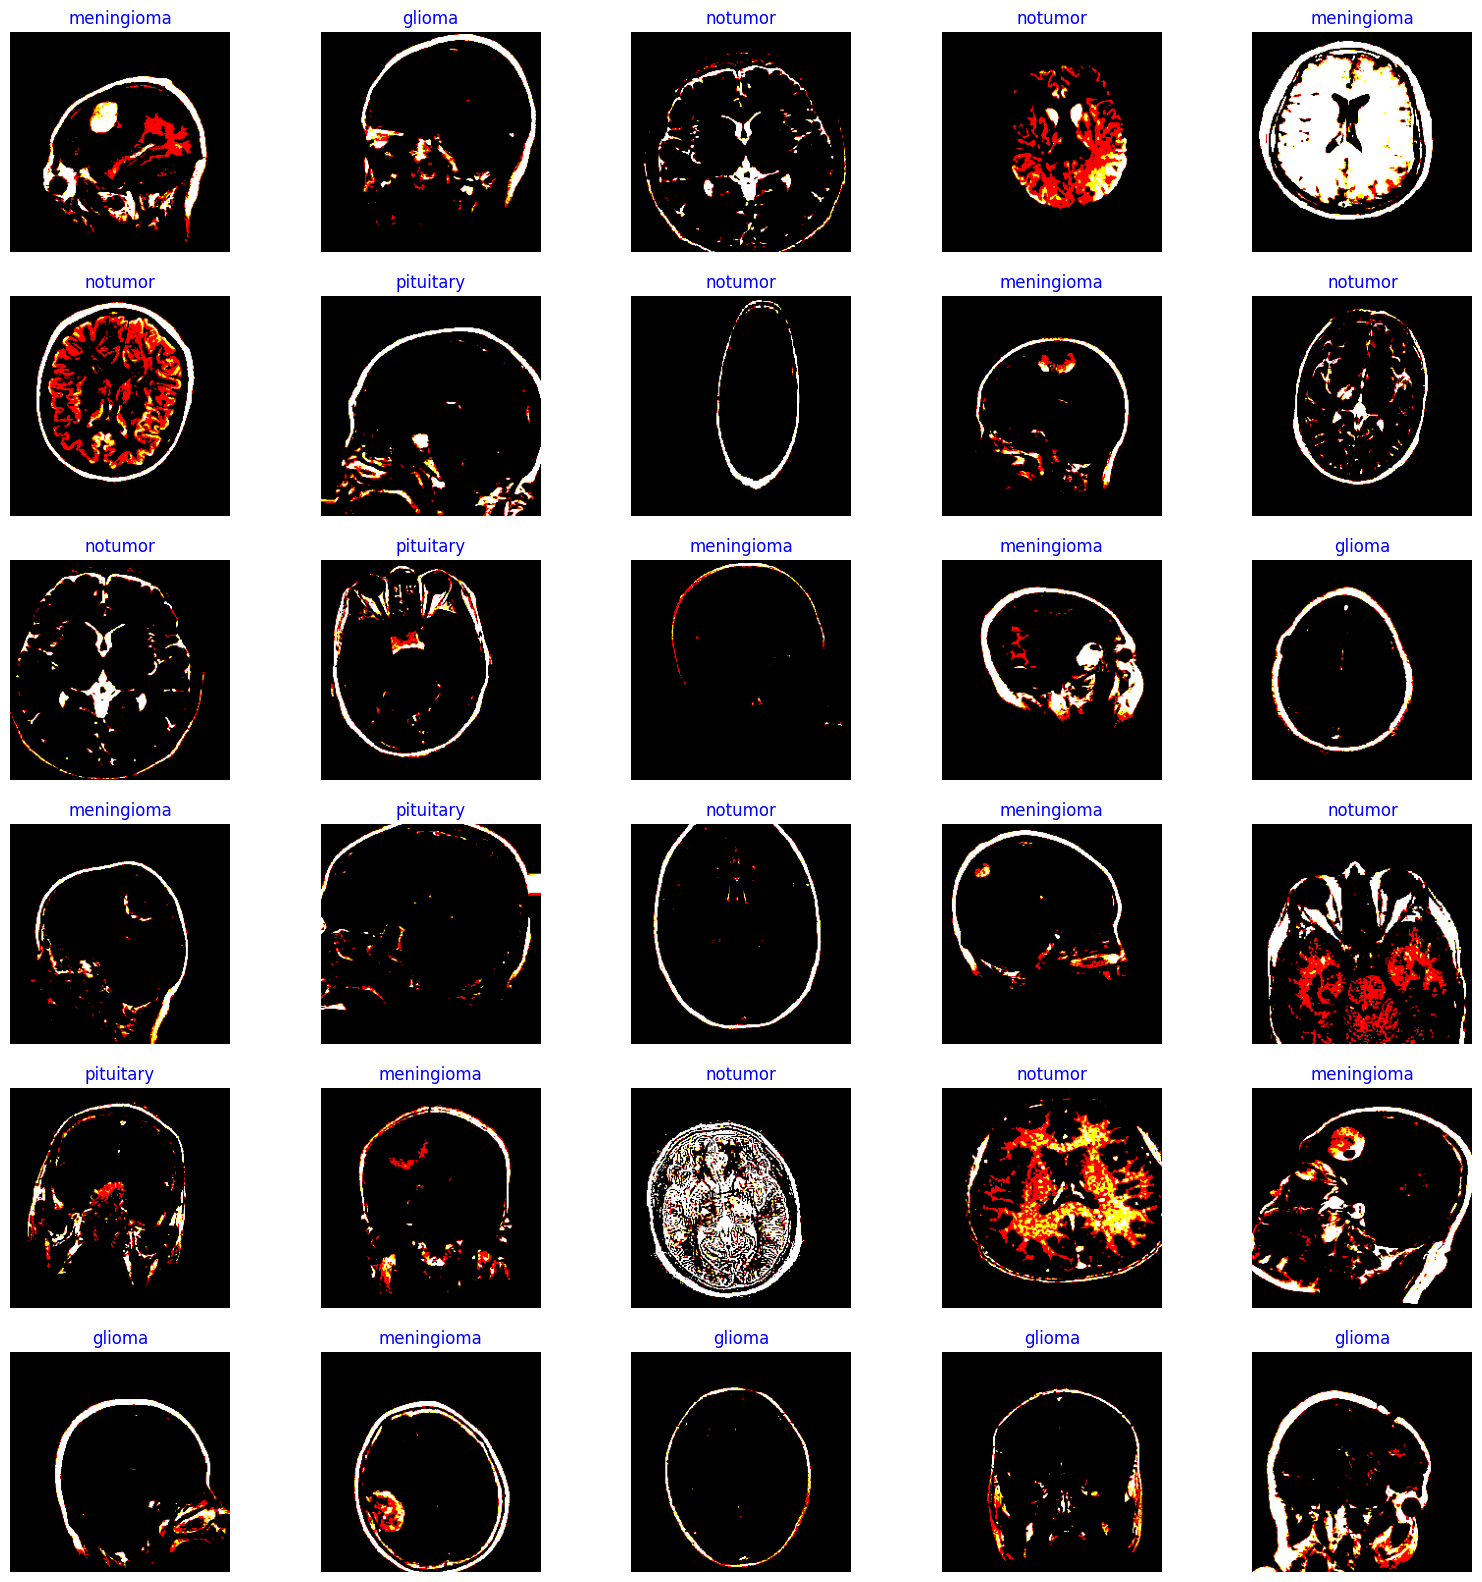

In [47]:
class_names = list(train_generator.class_indices.keys())

def plot_images():
        images, labels = next(train_generator)

        fig, axes = plt.subplots(6, 5, figsize=(20, 20))
        axes = axes.ravel()
        for i in np.arange(0, 30):
            axes[i].imshow(images[i])
            axes[i].set_title(class_names[np.argmax(labels[i])], color='b')
            axes[i].axis('off')

        plt.subplots_adjust(wspace=0.01)
        plt.show()

plot_images()

In [32]:
# Hyperparameters
from tensorflow.keras.optimizers import legacy

IMG_SHAPE = IMG_SIZE + (3,)
LOSS = keras.losses.CategoricalCrossentropy()
OPTIMIZER = legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
SEED = 42
# callbacks for the models
def get_callbacks (model_name):
  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'model.{model_name}.h5', monitor = 'val_loss', verbose = 1 ,
                                                    mode = 'min', save_best_only=True, save_freq='epoch')
  callbacks.append(checkpoint)
  rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
  callbacks.append(rlr)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
  callbacks.append(earlystop)

  return callbacks

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

In [33]:
callbacks = get_callbacks('Data_augmentation')

history = vgg_tuning.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=callbacks
)

Epoch 1/20
179/179 [==============================] - ETA: 0s - loss: 0.3607 - categorical_accuracy: 0.8925
Epoch 1: val_loss improved from inf to 0.22221, saving model to model.Data_augmentation.h5
179/179 [==============================] - 128s 662ms/step - loss: 0.3607 - categorical_accuracy: 0.8925 - val_loss: 0.2222 - val_categorical_accuracy: 0.9160 - lr: 0.0010
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 0.1607 - categorical_accuracy: 0.9380
Epoch 2: val_loss improved from 0.22221 to 0.13530, saving model to model.Data_augmentation.h5
179/179 [==============================] - 112s 628ms/step - loss: 0.1607 - categorical_accuracy: 0.9380 - val_loss: 0.1353 - val_categorical_accuracy: 0.9485 - lr: 0.0010
Epoch 3/20
179/179 [==============================] - ETA: 0s - loss: 0.1367 - categorical_accuracy: 0.9471
Epoch 3: val_loss did not improve from 0.13530
179/179 [==============================] - 109s 609ms/step - loss: 0.1367 - categorical_accuracy: 0

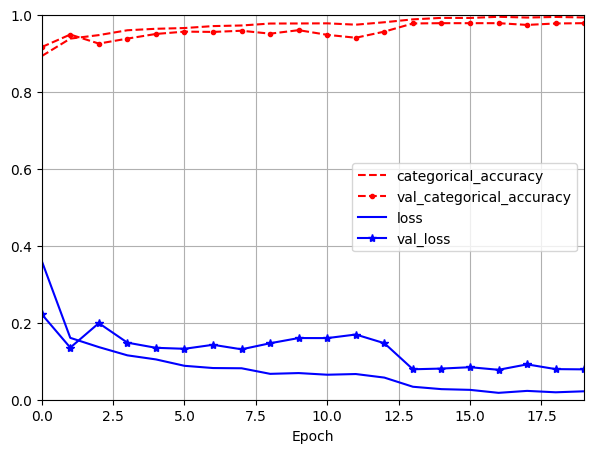

In [34]:
plot()

In [35]:
loss, categorical_accuracy = vgg_tuning.evaluate(test_dataset_vgg16)

42/42 [==============================] - 14s 318ms/step - loss: 0.0768 - categorical_accuracy: 0.9796


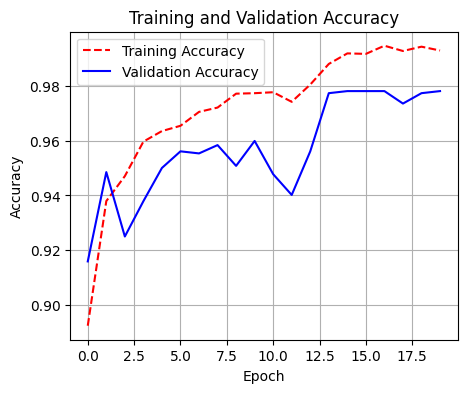

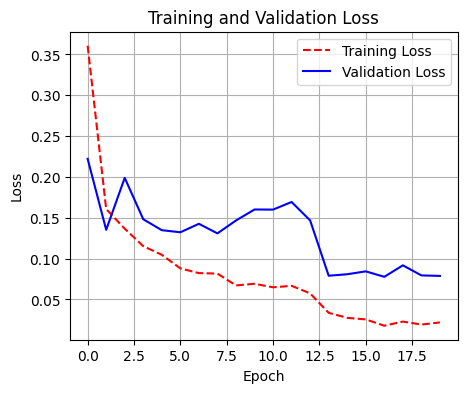

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(history):
    # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)

    # Plot training and validation accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['categorical_accuracy'], 'r--', label='Training Accuracy')
    plt.plot(history_df['val_categorical_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(5, 4))
    plt.plot(history_df['loss'], 'r--', label='Training Loss')
    plt.plot(history_df['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and stored the history object
plot(history)


42/42 [==============================] - 12s 273ms/step - loss: 0.0768 - categorical_accuracy: 0.9796
VGG - 16 - Test accuracy: 0.9796, Test loss: 0.0768
42/42 [==============================] - 9s 220ms/step

Classification Report for VGG - 16:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       310
           1       0.94      0.98      0.96       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.98      1321
   macro avg       0.98      0.98      0.98      1321
weighted avg       0.98      0.98      0.98      1321



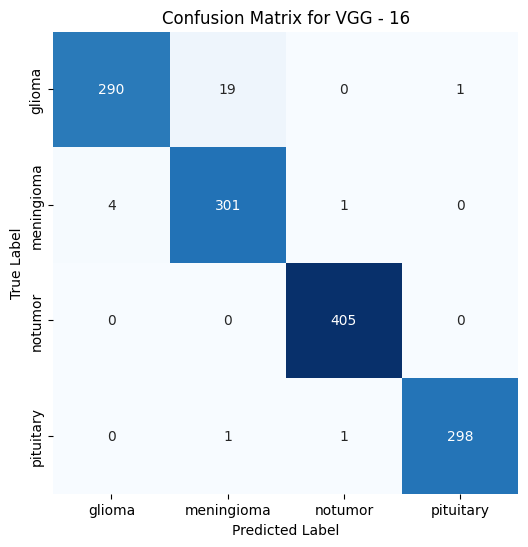

---


In [41]:
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def evaluate_model(model, name, test_dataset):
    # Evaluate the model on the test dataset
    test_loss, test_acc =  vgg_tuning.evaluate(test_dataset_vgg16)
    print(f"{name} - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # Generate predictions for the test set
    predictions = model.predict(test_dataset)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Convert labels to numpy array for classification report
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
    true_labels = np.array(true_labels)

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(true_labels, predicted_labels))

    # Create a colorful confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print("---")

# Now you can call the evaluate_model function with your datasets
evaluate_model(vgg_tuning, "VGG - 16", test_dataset_vgg16)
